In [1]:
import os
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import cv2

label_data =  loadmat("data/labels/imagelabels.mat")
split_data = loadmat("data/labels/setid.mat")

labels = label_data['labels'][0]
train_ids = split_data['trnid'][0]
valid_ids = split_data['valid'][0]
test_ids = split_data['tstid'][0]

print("Total images: ", len(labels))
print("Training images: ", len(train_ids))
print("Validation images: ", len(valid_ids))
print("Testing images: ", len(test_ids))

Total images:  8189
Training images:  1020
Validation images:  1020
Testing images:  6149


In [2]:
IMG_SIZE = 224
IMG_FOLDER = "data/flowers"

def load_and_preprocess_image(img_id):
    filename = f"image_{img_id:05d}.jpg"
    img_path = os.path.join(IMG_FOLDER, filename)

    image = cv2.imread(img_path)
    if image is None:
        return None
    
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    return image.astype(np.float32)


In [3]:
X_train = []
y_train = []

print("Loading training images.....")
for img_id in tqdm(train_ids):
    img = load_and_preprocess_image(img_id)
    if img is not None:
        X_train.append(img)
        y_train.append(labels[img_id-1])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("X_train shape:",X_train.shape)
print("y_train shape", y_train.shape)

X_valid =[]
y_valid = []

print("Loading validation images...")
for img_id in tqdm(valid_ids):
    img = load_and_preprocess_image(img_id)
    if img is not None:
        X_valid.append(img)
        y_valid.append(labels[img_id-1])

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)


print("X_valid shape:",X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_test =[]
y_test = []

print("Loading test images...")
for img_id in tqdm(test_ids):
    img = load_and_preprocess_image(img_id)
    if img is not None:
        X_test.append(img)
        y_test.append(labels[img_id-1])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape:",X_test.shape)
print("y_test shape:", y_test.shape)


Loading training images.....


100%|██████████| 1020/1020 [00:10<00:00, 95.05it/s]


X_train shape: (1020, 224, 224, 3)
y_train shape (1020,)
Loading validation images...


100%|██████████| 1020/1020 [00:09<00:00, 103.55it/s]


X_valid shape: (1020, 224, 224, 3)
y_valid shape: (1020,)
Loading test images...


100%|██████████| 6149/6149 [00:59<00:00, 103.31it/s]


X_test shape: (6149, 224, 224, 3)
y_test shape: (6149,)


In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()

# string labels into 0-101
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

# one-hot format for CNN model
y_train_cat = to_categorical(y_train_enc)
y_valid_cat = to_categorical(y_valid_enc)
y_test_cat  = to_categorical(y_test_enc)

print("y_train_cat shape:", y_train_cat.shape)

y_train_cat shape: (1020, 102)


In [9]:
#Simple CNN from Scratch
from tensorflow.keras.models import Sequential
from tensorflow.keras .layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(102, activation='softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 26, 26, 128)      

In [11]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

batch_size = 32
steps_per_epoch = len(X_train) // batch_size  

import matplotlib.pyplot as plt

history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs = 40,
                    validation_data = (X_valid, y_valid_cat),
                    verbose = 1)



Epoch 1/40
31/31 [==============================] - 44s 1s/step - loss: 4.6042 - accuracy: 0.0142 - val_loss: 4.5138 - val_accuracy: 0.0206
Epoch 2/40
31/31 [==============================] - 43s 1s/step - loss: 4.4497 - accuracy: 0.0243 - val_loss: 4.3011 - val_accuracy: 0.0265
Epoch 3/40
31/31 [==============================] - 45s 1s/step - loss: 4.3011 - accuracy: 0.0294 - val_loss: 4.1629 - val_accuracy: 0.0314
Epoch 4/40
31/31 [==============================] - 44s 1s/step - loss: 4.2185 - accuracy: 0.0263 - val_loss: 4.1025 - val_accuracy: 0.0480
Epoch 5/40
31/31 [==============================] - 43s 1s/step - loss: 4.1597 - accuracy: 0.0415 - val_loss: 4.0546 - val_accuracy: 0.0667
Epoch 6/40
31/31 [==============================] - 43s 1s/step - loss: 4.0769 - accuracy: 0.0617 - val_loss: 3.9733 - val_accuracy: 0.0676
Epoch 7/40
31/31 [==============================] - 42s 1s/step - loss: 3.9308 - accuracy: 0.0739 - val_loss: 3.8665 - val_accuracy: 0.0804
Epoch 8/40
31/31 [==

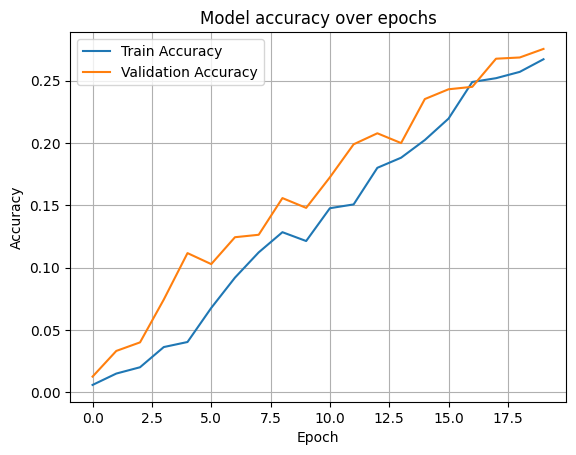

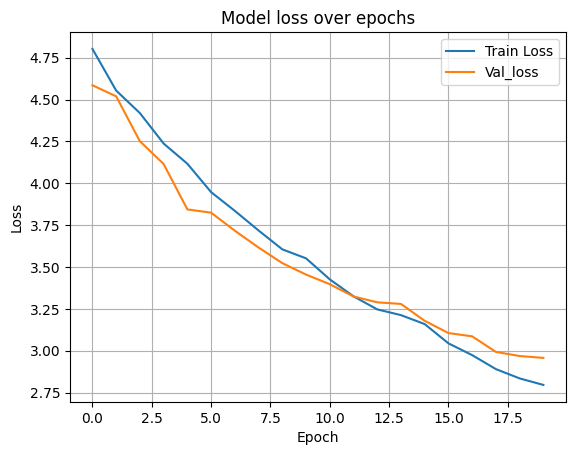

In [7]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.title("Model loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.save("smart_plant_model_v1.h5")


d:\Conda\envs\smartplant\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("smart_plant_model_v1.h5")

# Resume training
history = model.fit(datagen.flow(X_train, y_train_cat, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=20,  # Add more epochs
                    validation_data=(X_valid, y_valid_cat),
                    verbose=1)
